## Preprocessing

In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re, string, nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, FastText
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from scipy import sparse
import seaborn as sns

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

C:\ProgramData\Anaconda3\envs\news_classifier\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\malte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\malte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\malte\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Train test split and class distribution

Using custom data configuration default
Reusing dataset ag_news (C:\Users\malte\.cache\huggingface\datasets\ag_news\default\0.0.0\bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 333.33it/s]


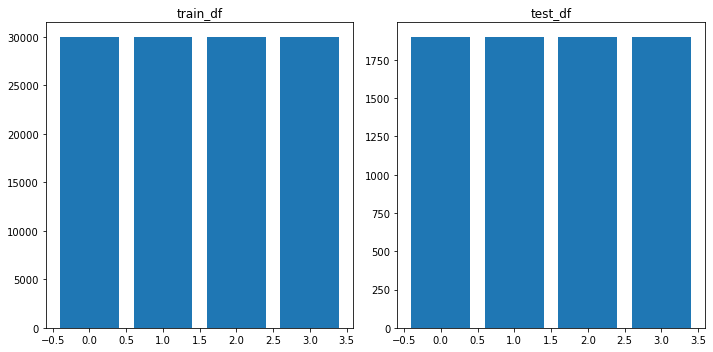

In [2]:
# train-test split
dataset = load_dataset("ag_news")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
del dataset

def class_distribution():
    
    # checking class distribution
    plt.figure(figsize=(10,5))

    ## train data
    plt.subplot(1,2,1)
    train_df_target = train_df['label']
    class_dist = pd.Series(train_df_target).value_counts()
    plt.title('train_df')
    plt.bar(class_dist.index, class_dist)
    plt.tight_layout()

    ## test data
    plt.subplot(1,2,2)
    test_df_target = test_df['label']
    class_dist = pd.Series(test_df_target).value_counts()
    plt.title('test_df')
    plt.bar(class_dist.index, class_dist)
    plt.tight_layout()

    plt.show()

def balanced_fractionize(df, frac):
    
    frac_df = df.sample(frac=frac, random_state=42)
    frac_data, frac_target = frac_df['text'].values.reshape(-1, 1), frac_df['label'].values.reshape(-1, 1)
    
    sampler = RandomUnderSampler()
    bal_frac_data, bal_frac_target = sampler.fit_resample(frac_data, frac_target)
    
    class_dist = pd.Series(bal_frac_target).value_counts()
    plt.bar(class_dist.index, class_dist)
    plt.ylabel("Frequency")
    plt.show()
    
    return pd.DataFrame(bal_frac_data, columns = ['text']), pd.DataFrame(bal_frac_target, columns = ['label'])

class_distribution()


In [3]:
#initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

#get the wordnet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # default pos
        return wordnet.NOUN

#text preprocessing
def preprocessing(text):
    
    # convert to lowercase and remove spaces at beginning and ending
    text = text.lower().strip()
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove html code
    text= re.sub('<.*?>', '', text) 
    
    # remove special characters
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove digits
    text = re.sub(r'\d',' ',text)
    
    # replace multiple whitespaces with one
    text = re.sub('\s+', ' ', text)
    
    # stop word removal
    clean_text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # tonkenize & lemmatize
    word_pos_tags = nltk.pos_tag(word_tokenize(clean_text)) # -> list of tuples (word, pos_tag) [('computer', 'NN'), ('word', 'tag')]
    lem_text = ' '.join([wnl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags])

    return lem_text

In [ ]:
# execute preprocessing for training set
train_df['text'] = train_df['text'].apply(lambda x: preprocessing(x))
train_df.to_csv('training_data.csv', sep=';', encoding='utf-8', index=False)
train_df.head()

In [ ]:
# execute preprocessing for test set
test_df['text'] = test_df['text'].apply(lambda x: preprocessing(x))
test_df.to_csv('preprocessed_test_data.csv', sep=';', encoding='utf-8', index=False)
test_df.head()

# Vectorization

## Reading in the preprocessed training data

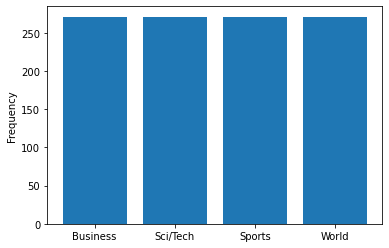

In [4]:
# read in preprocessed training data if necessary
train_df = pd.read_csv('preprocessed_training_data.csv', sep=';', encoding='utf-8')

train_df.loc[(train_df.label == 0),'label']='World'
train_df.loc[(train_df.label == 1),'label']='Sports'
train_df.loc[(train_df.label == 2),'label']='Business'
train_df.loc[(train_df.label == 3),'label']='Sci/Tech'

train_df['label']= train_df['label'].astype(str)


#fractionize and undersample data
train_data, train_target = balanced_fractionize(train_df, 0.2)

#Tokenize
def get_train_tokens(df_data):
    return [word_tokenize(text) for text in df_data['text']]

## Training the vectorizers on the training data

### TF IDF & Count Vectors

In [5]:
tf_count_std_parameters = {
    'max_features': 10000,
}

# tf idf
vectorizer_tf_idf = TfidfVectorizer(**tf_count_std_parameters)
tf_idf_vectors = vectorizer_tf_idf.fit_transform(train_df['text'])

In [6]:
# count
vectorizer_count = CountVectorizer(**tf_count_std_parameters)
count_vectors = vectorizer_count.fit_transform(train_df['text'])

### Word2Vec SkipGram & CBOW

In [23]:

wordEmbedding_std_parameters = {
    'window': 8,
    'vector_size': 100,
    'min_count': 5
}

# get tokens
tokens = get_train_tokens(train_df)

# Train the models on the training data once

#w2v_cbow = Word2Vec(tokens, **wordEmbedding_std_parameters)
#w2v_skipg = Word2Vec(tokens, **wordEmbedding_std_parameters, sg = 1)

#w2v_cbow.save("w2v_cbow.model")
#w2v_skipg.save("w2v_skipg.model")

w2v_cbow = Word2Vec.load("w2v_cbow.model")
w2v_skipg = Word2Vec.load("w2v_skipg.model")

### fastText

In [9]:
# train model once on the training data
fasttext = FastText(**wordEmbedding_std_parameters)
fasttext.build_vocab(corpus_iterable=tokens)
fasttext.train(corpus_iterable=tokens, total_examples=len(tokens), epochs=10)

(29762136, 31006020)

### GloVe

In [ ]:
# write content into file
# with open('corpus.txt', 'w') as f:
#     for text in train_df['text'].tolist():
#         f.write(text + '\n')
# train vectors with https://github.com/stanfordnlp/GloVe with standard parameters (window=8, size=100, MIN_COUNT=5)

In [10]:
# get the vocab and the vectors after training
vocab = []
vectors = {}
with open('vocab.txt') as f:
    for ln in f:
        words = ln.split()
        vocab = vocab + words[:1]
with open('vectors.txt') as f:
    for ln in f:
        word = ln.split()[0]
        vector = [float(number) for number in ln.split()[1:]]
        vectors[word] = vector

## Functions for getting the vectors for a given data set

In [11]:
def get_tfid_vectors(df_data):
    return vectorizer_tf_idf.transform(df_data['text'])

def get_count_vectors(df_data):
    return vectorizer_count.transform(df_data['text'])

# returns mean vector for list of specified words
def get_embedding(model, text):
    existing_words = [word for word in text if word in list(model.wv.index_to_key)]
    if existing_words:
        embedding = np.zeros((len(existing_words), model.vector_size), dtype=np.float32)
        for i, w in enumerate(existing_words):
                embedding[i] = model.wv[w]
        return np.mean(embedding, axis=0)
    else:
        return np.zeros(model.vector_size)

    
# get the embeddings of the trained model for the tokens
def get_w2v_cbow_embeddings(tokens):
    return np.array([get_embedding(w2v_cbow, text) for text in tokens])

# get the embeddings of the trained model for the tokens
def get_w2v_skipg_embeddings(tokens):
    return np.array([get_embedding(w2v_skipg, text) for text in tokens])

def get_fasttext_embeddings(tokens):
    return np.array([get_embedding(fasttext, text) for text in tokens])

def get_glove_document_vector(text, vocab, vectors, vector_size):
    existing_words = [word for word in text if word in vocab]
    if existing_words:
        embedding = np.zeros((len(existing_words), vector_size), dtype=np.float32)
        for i, w in enumerate(existing_words):
                embedding[i] = vectors[w]
        return np.mean(embedding, axis=0)
    else:
        return np.zeros(model.vector_size)
    

# needs tokens from same fraction of training data as the GloVe embeddings were trained with
def get_glove_embeddings(tokens):
    return np.array([get_glove_document_vector(text, vocab, vectors, len(vector)) for text in tokens])

In [12]:
#returns vectors for specified vectorizer and data
def get_Vectors(vectorizer_name, df_data):
        
        if vectorizer_name == "tfidf_vectors":
            return get_tfid_vectors(df_data)
        
        elif vectorizer_name == "count_vectors":
            return get_count_vectors(df_data)
            
        elif vectorizer_name == "w2v_cbow":
            train_tokens = get_train_tokens(df_data)
            return get_w2v_cbow_embeddings(train_tokens)
            
            
        elif vectorizer_name == "w2v_skipg":
            train_tokens = get_train_tokens(df_data)
            return get_w2v_skipg_embeddings(train_tokens)
            
        elif vectorizer_name == "fasttext":
            train_tokens = get_train_tokens(df_data)
            return get_fasttext_embeddings(train_tokens, wordEmbedding_std_parameters)
            
        elif vectorizer_name == "GloVe":
            train_tokens = get_train_tokens(df_data)
            return get_glove_embeddings(train_tokens)

## Classification

### Hyperparameter Tuning

In [13]:
# hyperparameter tuning
def param_search(vector_matrix, vector_matrix_name, estimator):
    
    estimator_name = estimator['name']
    parameters = estimator['parameters']
    estimator = estimator['estimator']
    
    # configure the cross-validation procedure
    cv_outer = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # enumerate splits
    outer_results = list()
    X = vector_matrix
    y = train_target['label']
    
    for train_ix, test_ix in cv_outer.split(X,y):
        
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
    
        # specify the nested cross validation
        nested_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

        # create the grid search instance
        search = GridSearchCV(estimator, parameters, scoring='accuracy', cv=nested_cv, n_jobs=-1)
        
        # execute search
        result = search.fit(vector_matrix, train_target['label'])
        
        # get the best performing model fit on the whole training set
        best_estimator = result.best_estimator_
        
        # evaluate model on the hold out dataset
        predictions = best_estimator.predict(X_test)
        
        # evaluate the model
        acc = accuracy_score(y_test, predictions)
        
        # store the result
        outer_results.append(acc)
        
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    # summarize the estimated performance of the model
    accuracy_mean = np.mean(outer_results)
    
    #print the best parameter setting
    print("Classifier: {}".format(estimator_name))
    print("Vectorizer: {}".format(vector_matrix_name))
    print("Mean Accuracy: {}".format(accuracy_mean))
    print()
    
    return accuracy_mean, best_estimator

In [14]:
# tune for the best vectorizer-estimator combination
def hyper_tune():
    
    kNeighbors_parameters = {
        'n_neighbors': [10,12,14] 
    }
    
    decisionTree_parameters = {
        'criterion':['gini', 'entropy'], 
        'max_depth': [40,60,80,100],
        'min_samples_split' : [20,30,40]
    }
    
    
    GaussianNB_parameters = {       

    }
    
    svc_parameters = {
        'gamma': ['auto', 'scale'],
        'kernel': ['rbf','sigmoid']
    }
    
    mlpClassifier_parameters = {
        'activation': ['tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'hidden_layer_sizes':[(50,50,50), (50,100,50), (100,)],
        'learning_rate': ['constant', 'adaptive']
    }
    
    rfc_parameters = {
        'max_depth': [40,60,80,100], 
        'max_features': ['sqrt'],
        'n_estimators': [100,200,300]
    } 
    
    
    # ------ VECTORIZERS ------
    train_tokens = get_train_tokens(train_data)
    
    vectorizer_names = ["tfidf_vectors", "count_vectors", "w2v_cbow", "w2v_skipg", "fasttext", "GloVe"]

    vectorizer_values = [
        get_tfid_vectors(train_data), get_count_vectors(train_data),
        get_w2v_cbow_embeddings(train_tokens), get_w2v_skipg_embeddings(train_tokens),
       get_fasttext_embeddings(train_tokens),get_glove_embeddings(train_tokens)
    ]

    del train_tokens
    vectorizers = dict(zip(vectorizer_names, vectorizer_values))
    print('vectorizers calculated')
    

    
    # ------ ESTIMATORS ------
    #TODO: add more estimators
    estimators = {
        'KNeighborsClassifier': { 'name': 'KNeighborsClassifier', 'estimator': KNeighborsClassifier(), 'parameters': kNeighbors_parameters },
        #'DecisionTreeClassifier': { 'name': 'DecisionTreeClassifier', 'estimator': DecisionTreeClassifier(), 'parameters': decisionTree_parameters },
        #'GaussianNB': { 'name': 'GaussianNB', 'estimator': GaussianNB(), 'parameters': GaussianNB_parameters },
        #'SVC': { 'name': 'SVC', 'estimator': SVC(probability=True), 'parameters': svc_parameters },
        #'MLPClassifier': { 'name': 'MLPClassifier', 'estimator': MLPClassifier(max_iter=500), 'parameters': mlpClassifier_parameters },
        #'RandomForestClassifier': { 'name': 'RandomForestClassifier', 'estimator': RandomForestClassifier(), 'parameters': rfc_parameters }

    }
    
    
    best_score = 0
    for vectorizer in vectorizers:
        for estimator in estimators:
            if not ((vectorizer == 'tfidf_vectors' or vectorizer == 'count_vectors') and estimator == 'GaussianNB'):
                score, model = param_search( vectorizers[vectorizer], vectorizer, estimators[estimator] )
                if score > best_score:
                    best_score = score
                    best_estimator_name = estimator
                    best_vectorizer_name = vectorizer
                    best_estimator = model

    print("\nThe best performance is reached with the estimator " + best_estimator_name + " and the vectorizer " + best_vectorizer_name + " with an accuracy of " + str(best_score) )
    return best_estimator, best_vectorizer_name, vectorizers


#the best performing model and vectorizer
estimator, vectorizer_name, vectorizers = hyper_tune()

vectorizers calculated
>acc=0.873, est=0.756, cfg={'n_neighbors': 12}
>acc=0.809, est=0.756, cfg={'n_neighbors': 12}
>acc=0.839, est=0.756, cfg={'n_neighbors': 12}
Classifier: KNeighborsClassifier
Vectorizer: tfidf_vectors
Mean Accuracy: 0.8403758742596533

>acc=0.544, est=0.399, cfg={'n_neighbors': 12}
>acc=0.560, est=0.399, cfg={'n_neighbors': 12}
>acc=0.515, est=0.399, cfg={'n_neighbors': 12}
Classifier: KNeighborsClassifier
Vectorizer: count_vectors
Mean Accuracy: 0.5396637129316457

>acc=0.903, est=0.868, cfg={'n_neighbors': 14}
>acc=0.861, est=0.868, cfg={'n_neighbors': 14}
>acc=0.884, est=0.868, cfg={'n_neighbors': 14}
Classifier: KNeighborsClassifier
Vectorizer: w2v_cbow
Mean Accuracy: 0.8828224238992363

>acc=0.914, est=0.870, cfg={'n_neighbors': 10}
>acc=0.900, est=0.870, cfg={'n_neighbors': 10}
>acc=0.892, est=0.870, cfg={'n_neighbors': 10}
Classifier: KNeighborsClassifier
Vectorizer: w2v_skipg
Mean Accuracy: 0.9022028027323324

>acc=0.884, est=0.835, cfg={'n_neighbors': 10}

## Hyperparameter tuning for Vectorizors on a given classifier

##### For the best model, vectorizer combination execute vectorizer hyperparameter tuning (not for GloVe, since its trained in C)
##### Only provides local optimum for the provided classifier 

In [15]:
# vectorizer_name is one of the following 'w2v_cbow' / 'w2v_skipg' / 'fasttext' / 'tfidf_vectors' / 'count_vectors'
# returns best parameter combination for vectorizer 'vectorizer_name' with given classifier
def hypertuneVectorizor(estimator, vectorizer_name):
    
    best_acc = 0
    best_model = {}
    parameters = ParameterGrid({})
    
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=22)
    
    if vectorizer_name == 'tfidf_vectors' or vectorizer_name == 'count_vectors':
        
        parameters = ParameterGrid({
        'ngram_range': [(1,1), (1,2)],
        'max_features': [10000, 30000, 50000, 80000],
        'min_df': [1, 2, 5]
        })
        
    
    elif vectorizer_name == 'GloVe':
        return None
    
    else:
        
        parameters = ParameterGrid({
        'min_count': [5, 8],
        'vector_size': [50, 100, 200],
        'window': [5, 8, 10]
        })
        
        train_df_tokens = get_train_tokens(train_df)
        train_tokens = get_train_tokens(X_train)
        test_tokens = get_train_tokens(X_test)


    print("Hyperparametertuning for Vectorizer", vectorizer_name, "given estimator", estimator, "\n")
    for param_comb in parameters:
         
        if vectorizer_name == 'tfidf_vectors':
            
            vec_model = TfidfVectorizer(**param_comb)
            vec_model.fit_transform(train_df['text'].values.ravel())
            
            emb_train = vec_model.transform(X_train['text'])
            emb_test = vec_model.transform(X_test['text'])
                
        elif vectorizer_name == 'count_vectors':
                
            vec_model = CountVectorizer(**param_comb)
            vec_model.fit_transform(train_df['text'].values.ravel())
            
            emb_train = vec_model.transform(X_train['text'])
            emb_test = vec_model.transform(X_test['text'])
            
        elif vectorizer_name == 'w2v_cbow':
                
            vec_model = Word2Vec(train_df_tokens, **param_comb)
            emb_train = np.array([get_embedding(vec_model, text) for text in train_tokens])
            emb_test = np.array([get_embedding(vec_model, text) for text in test_tokens])
                
        elif vectorizer_name == 'w2v_skipg':
            
            vec_model = Word2Vec(train_df_tokens, **param_comb, sg=1)
            emb_train = np.array([get_embedding(vec_model, text) for text in train_tokens])
            emb_test = np.array([get_embedding(vec_model, text) for text in test_tokens])
            
                
        elif vectorizer_name == 'fasttext':

            vec_model = FastText(**param_comb)
            vec_model.build_vocab(corpus_iterable=train_df_tokens)
            vec_model.train(corpus_iterable=train_df_tokens, total_examples=len(train_df_tokens), epochs=10)
            
            emb_train = np.array([get_embedding(vec_model, text) for text in train_tokens])
            emb_test = np.array([get_embedding(vec_model, text) for text in test_tokens])
                
                
        model = estimator.fit(emb_train, y_train['label'])
        predictions = model.predict(emb_test)
        probabilities = model.predict_proba(emb_test)

        
        acc = accuracy_score(y_test['label'].to_numpy(), predictions)
        print("Accuracy:", round(acc,2), "   Parameter Combination:", param_comb)
        
        if acc > best_acc:
            best_acc = acc
            best_model = {'vectorizer': vectorizer_name, 'parameters': param_comb, 'acc': best_acc, 'model': vec_model}
            best_param = param_comb
    
    print("Best parameter combination:", best_param)
    return best_model, predictions, probabilities

In [16]:
best_model, predictions, probabilities = hypertuneVectorizor(estimator, vectorizer_name)

Hyperparametertuning for Vectorizer w2v_skipg given estimator KNeighborsClassifier(n_neighbors=10) :

Accuracy: 0.86    Parameter Combination: {'min_count': 5, 'vector_size': 50, 'window': 5}
Accuracy: 0.86    Parameter Combination: {'min_count': 5, 'vector_size': 50, 'window': 8}
Accuracy: 0.87    Parameter Combination: {'min_count': 5, 'vector_size': 50, 'window': 10}
Accuracy: 0.86    Parameter Combination: {'min_count': 5, 'vector_size': 100, 'window': 5}
Accuracy: 0.86    Parameter Combination: {'min_count': 5, 'vector_size': 100, 'window': 8}
Accuracy: 0.87    Parameter Combination: {'min_count': 5, 'vector_size': 100, 'window': 10}
Accuracy: 0.86    Parameter Combination: {'min_count': 5, 'vector_size': 200, 'window': 5}
Accuracy: 0.86    Parameter Combination: {'min_count': 5, 'vector_size': 200, 'window': 8}
Accuracy: 0.85    Parameter Combination: {'min_count': 5, 'vector_size': 200, 'window': 10}
Accuracy: 0.86    Parameter Combination: {'min_count': 8, 'vector_size': 50, 'w

In [18]:
# reassign the vectorizer model with new local optimum
if vectorizer_name == 'tfidf_vectors':
    vectorizer_tf_idf = best_model['model']
    
elif vectorizer_name == 'count_vectors':
    vectorizer_count = best_model['model']
    
elif vectorizer_name == 'w2v_cbow':
    w2v_cbow = best_model['model']

        
elif vectorizer_name == 'w2v_skipg':
    w2v_skipg = best_model['model']

        
elif vectorizer_name == 'fasttext':
    fasttext = best_model['model']

# Evaluation

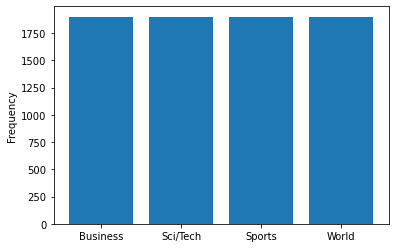

In [19]:
# read in preprocessed test data if necessary
test_df = pd.read_csv('preprocessed_test_data.csv', sep=';', encoding='utf-8')

test_df.loc[(test_df.label == 0),'label']='World'
test_df.loc[(test_df.label == 1),'label']='Sports'
test_df.loc[(test_df.label == 2),'label']='Business'
test_df.loc[(test_df.label == 3),'label']='Sci/Tech'

test_df['label']= test_df['label'].astype(str)

test_data, test_target = balanced_fractionize(test_df, 1.0)

In [24]:
#Train the model on the specified fraction of training data
def train_model(df_data, df_target, vectorizer_name):
    return estimator.fit(get_Vectors(vectorizer_name, df_data), df_target['label'])


#make predictions
def predict(train_data, train_target, vectorizer_name, estimator):

    #get the trained model
    model = train_model(train_data, train_target, vectorizer_name)    

    return model.predict(get_Vectors(vectorizer_name, test_data)), model.predict_proba(get_Vectors(vectorizer_name, test_data))


predictions, probs = predict(train_data, train_target, vectorizer_name, estimator)

In [21]:
#shows results from evaluation metrics
def evaluation_figures(predictions, probs, test_target):
    
    # get all unique classes
    classes = np.unique(test_target)

    # evaluate the model
    accuracy = accuracy_score(test_target['label'].to_numpy(), predictions)
    auc_score = roc_auc_score(test_target['label'].to_numpy(), probs, multi_class="ovr")
    print("Model: ", )
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc_score,2))
    print("Detail:")
    print(classification_report(test_target, predictions))

    ## Plot confusion matrix
    cm = confusion_matrix(test_target, predictions)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2)

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(test_target['label'].to_numpy(),  
                               probs[:,i], pos_label=classes[i])
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(fpr, tpr))
                   )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
                     test_target['label'].to_numpy(), probs[:,i], pos_label=classes[i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)


    fig.set_figheight(5)
    fig.set_figwidth(15)
    plt.show()

Model: 
Accuracy: 0.87
Auc: 0.97
Detail:
              precision    recall  f1-score   support

    Business       0.84      0.81      0.82      1900
    Sci/Tech       0.81      0.86      0.83      1900
      Sports       0.92      0.97      0.94      1900
       World       0.92      0.84      0.88      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



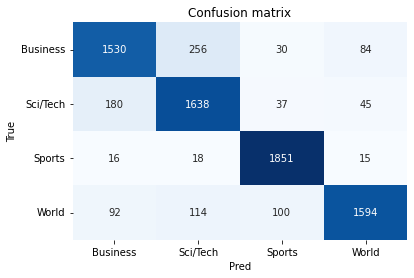

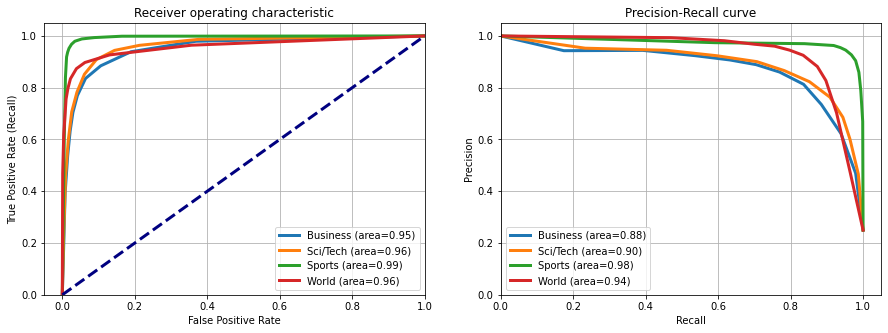

In [25]:
evaluation_figures(predictions, probs, test_target)